# MaNGA RSS File Tests

In this example notebook, I test `RealSim-IFS` on real data from the MaNGA survey.

In [2]:
import os,sys,time
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from shutil import copy as cp
from glob import glob
from copy import copy
import RealSim_IFS
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings("ignore")

from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)


## Information on SDSS-IV MaNGA data

Data Access: https://www.sdss.org/dr16/manga/manga-data/data-access/ 

Data Model: https://www.sdss.org/dr14/manga/manga-data/data-model/

In this test, I download a MaNGA `RSS` file (row-reduced spectra) and generate a cube using `RealSim-IFS`. I then compare the output with the MaNGA DRP `CUBE` for the same object. The output should be similar apart from factors such as astrometric corrections, differential atmospheric refraction (DAR), which are accounted for to ~0.1 arcsec accuracy by the MaNGA DRP.

In [3]:
if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
    wdir = os.environ['SLURM_TMPDIR']
    os.chdir(wdir)
    print(os.getcwd())
    
else:
    wdir = '/Users/cbottrell/Project/RealSim-IFS/Work'
    os.chdir(wdir)
    print(os.getcwd())

/localscratch/bottrell.42770540.0


## Get file from science archive server

Using the `rsync` method.

In [4]:

sas_base_dir = 'rsync://data.sdss.org/dr16/manga/spectro/redux/v2_4_3'

plate = 7443
ifudesign = 12703

filename = 'manga-{PLATE}-{IFUDESIGN}-LINRSS.fits.gz'.format(PLATE=plate,IFUDESIGN=ifudesign)
target_url = '{}/{}/stack/{}'.format(sas_base_dir,plate,filename)

if not os.access(filename,0):
    rsync_cmd = 'rsync -avz --info=progress2 {} ./{}'.format(target_url,filename)
    start = time.time()
    os.system(rsync_cmd)
    print(time.time()-start)
   

10.030817747116089


## Move file to local working directory

(working directory) and unzip. 

In [5]:
plate = 7443
ifudesign = 12703
filename = 'manga-{PLATE}-{IFUDESIGN}-LINRSS.fits.gz'.format(PLATE=plate,IFUDESIGN=ifudesign)

data_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Data'

if os.access(data_dir,0):

    if not os.access('{}/{}'.format(wdir,filename),0):
        cp('{}/{}'.format(data_dir,filename),wdir)
    os.system('gunzip -f {}'.format(filename))


## File exploration

https://data.sdss.org/datamodel/files/MANGA_SPECTRO_REDUX/DRPVER/PLATE4/stack/manga-RSS.html

Note that dimension 0 of the `FLUX` data in the `rss` file is 1905 which is an integer multiple of 127 fibers and 3 dithered exposures. The other dimension is `Nels` (the number of spectral elements).

Below I show a single spectrum. The wavelength array for all spectra is in the `WAVE` HDU.

(3700.0, 10250.0)

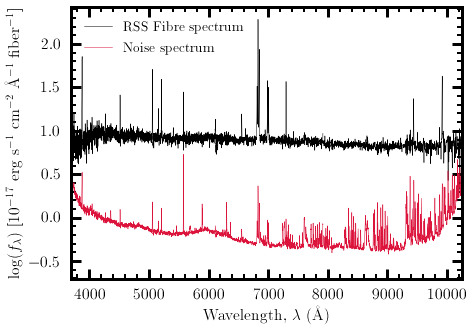

In [6]:
rssname = filename.replace('.gz','')

hdu = fits.open(rssname)

rss = hdu['FLUX'].data
lam = hdu['WAVE'].data
isigma = np.sqrt(hdu['IVAR'].data)
sigma = 1./isigma

# find appropriate spectrum for plotting
sums = np.nansum(rss,axis=1)
index = np.argmax(sums)+3

fig,ax = plt.subplots(1,1,figsize=(7,5))

ax.minorticks_on()
ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=16,right=1,top=1)
ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
ax.tick_params(axis='both',which='major',pad=10)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
        
ax.plot(lam,np.log10(rss[index]),c='black',linewidth=0.5,label='RSS Fibre spectrum')
ax.plot(lam,np.log10(sigma[index]),c='crimson',linewidth=0.5,label='Noise spectrum')
ax.set_xlabel(r'Wavelength, $\lambda$ (\AA)',fontsize=16)
ax.set_ylabel(r'$\log(f_{\lambda})$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$ fiber$^{-1}$]',fontsize=16)
ax.legend(frameon=False,loc='upper left',fontsize=14,framealpha=1)
ax.set_xlim(3700,10250)


## Infographic on RSS files

Below I touch up an infographic on RSS files using the 7443-12703.

(0.0, 1.0)

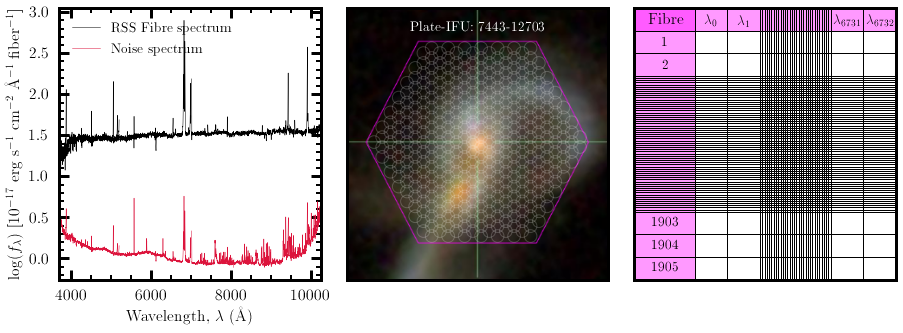

In [7]:
rssname = filename.replace('.gz','')

hdu = fits.open(rssname)

rss = hdu['FLUX'].data
lam = hdu['WAVE'].data
isigma = np.sqrt(hdu['IVAR'].data)
sigma = 1./isigma

# find appropriate spectrum for plotting
sums = np.nansum(rss,axis=1)
index = np.argsort(sums)[-1]

fig,axarr = plt.subplots(1,3,figsize=(15,5))
fig.subplots_adjust(wspace=0.1)

ax = axarr[0]
ax.minorticks_on()
ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=16,right=1,top=1)
ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
ax.tick_params(axis='both',which='major',pad=10)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
        
ax.plot(lam,np.log10(rss[index]),c='black',linewidth=0.5,label='RSS Fibre spectrum')
ax.plot(lam,np.log10(sigma[index]),c='crimson',linewidth=0.5,label='Noise spectrum')
ax.set_xlabel(r'Wavelength, $\lambda$ (\AA)',fontsize=16)
ax.set_ylabel(r'$\log(f_{\lambda})$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$ fiber$^{-1}$]',fontsize=16)
ax.legend(frameon=False,loc='upper left',fontsize=14,framealpha=1)
ax.set_xlim(3700,10250)

ax = axarr[1]

griimage_name = '/scratch/bottrell/Merger_Kinematics/RealSim-IFS/Figures/7443-12703_gri.png'
img = copy(mpimg.imread(griimage_name))
ax.imshow(img,aspect='auto')
ax.tick_params(axis='both',which='major',right=0,top=0,bottom=0,left=0,labelbottom=False,labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    
(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='N127',
                                       fibers_per_side=None,
                                       n_observations='Classic',
                                       rotation_degrees = 0.,
                                       return_params=True)
factor = 7.7
xc_arr*=factor
yc_arr*=factor
xc_arr+=img.shape[0]/2+1
yc_arr+=img.shape[1]/2-2
    
ax.scatter(xc_arr.flatten(),yc_arr.flatten(),facecolor = 'None',edgecolor='white',s=160,alpha=0.2)
ax.set_xlim(0,img.shape[0])
ax.set_ylim(img.shape[1],0)

ax.text(0.5,0.95,"Plate-IFU: {}-{}".format(plate,ifudesign),
        ha='center',va='top',color='white',fontsize=14,transform=ax.transAxes)


ax = axarr[2]

ax.tick_params(axis='both',which='major',right=0,top=0,bottom=0,left=0,labelbottom=False,labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    
for i in range(4):
    ax.axhline(i/12,lw=1,c='black')
    if i<3:
        ax.text(0.12,i/12+1/24,1905-i,ha='center',va='center',fontsize=14)

for i in range(4):
    ax.axhline(1-i/12,lw=1,c='black')
    if i>0 and i<3:
        ax.text(0.12,1-(i/12+1/24),i,ha='center',va='center',fontsize=14)
    
for i in np.linspace(3/12,1-3/12,64):
    ax.axhline(i,lw=1,c='black')
    
ax.text(0.05,1-1/24,"Fibre",ha='left',va='center',fontsize=16)

for i,x in enumerate(np.linspace(0.23,0.48,3)):
    ax.axvline(x,lw=1,c='black')
    if i<2:
        ax.text(x+2/32,1-2/36,"$\lambda_{{{}}}$".format(i),fontsize=14,ha='center',va='center')
        
for i,x in enumerate(np.linspace(0.48,1-0.25,32)):
    ax.axvline(x,lw=1,c='black')
    
for i,x in enumerate(np.linspace(1-0.25,1,3)):
    ax.axvline(x,lw=1,c='black')
    if i<2:
        ax.text(x+2/32,1-2/36,"$\lambda_{{{}}}$".format(6731+i),fontsize=14,ha='center',va='center')
        
ax.fill_betweenx([0,1],x1=0,x2=0.23,color='magenta',alpha=0.4)
ax.fill_between([0,1],y1=1-1/12,y2=1,color='magenta',alpha=0.4)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#fig.savefig('RSS_File_Demo.pdf',bbox_inches='tight')

## The `OBSINFO` Extension

The `OBSINFO` extension contains information about each exposure. First, note that the shape of data in this extension is 15 -- corresponding to the $5 \times 3$ dithered exposures taken. One thing in which we are interested is the guide-star seeing (arcsec) before convolution with the instrument. There are 15 values, one for each exposure. We could appropriately take the median seeing of these exposures and apply it to the input data cubes with using a kernel constructed from two Gaussian profiles:

9/13 * Gaussian(FWHM = Theta) + 4/13 * Gaussian(FWHM = 2 * Theta) where Theta = SEEING/1.05

There is a weak FWHM$(\lambda)$ = FWHM$_{5000A} \times (\lambda\;/\;5000A)^{-0.2}$ 

where FWHM$_{5000A}$ is the Full Width at Half Maximum at 5000 Angstroms reported in the `OBSINFO` file.

In [8]:
obsinfo = hdu['OBSINFO']
exp_seeing = obsinfo.data['SEEING']

lam = 6000 # angstrom

seeing5000A = np.median(exp_seeing)

def seeing(seeing5000A,lam):
    return seeing5000A * (lam/5000)**(-0.2)

fwhm_lam = seeing(seeing5000A, lam)
print(fwhm_lam)


1.5858169999624556


## The `XPOS` and `YPOS` Extensions

These provide the effective wavelength dependent x and y positions of the all fiber centroids from each exposure accounting for DAR and other astrometry effects. In the left panel, note the slight irregularities in the median position of the fibers computed over all wavelength elements. Corrections which account for these position offsets are made in the MaNGA DRP and are illustrated in the right panel. The blue circles are the "effective" fiber positions in the first wavelength element for a single exposure. The green and red are the corresponding "effective" positions in the 1000th and last wavelength element.

For deep learning applications, the slight counter-clockwise rotation of the pattern can be accounted for with augmentation. Rotations are also allowed as part of `RealSim-IFS`'s `MaNGA_Observe` method.

(1905, 6732)
3622.0 4622.0 10353.0


Text(10, -16.0, '10353 \\AA')

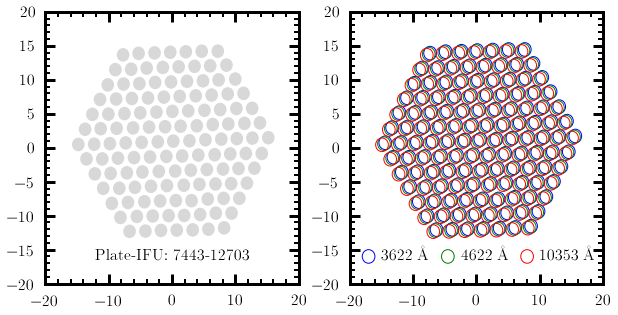

In [9]:


xpos = hdu['XPOS'].data
ypos = hdu['YPOS'].data
print(xpos.shape)

lam = hdu['WAVE'].data
med_xpos = np.median(xpos,axis=1)
med_ypos = np.median(ypos,axis=1)
lam_index = 1000

print(lam[0],lam[lam_index],lam[-1])

fig,axarr = plt.subplots(1,2,figsize=(10,5))

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=16,right=1,top=1)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)

ax = axarr[0]

for xy in zip(med_xpos[:127],med_ypos[:127]):
    core = Circle(xy=xy,radius=1,transform=ax.transData,facecolor='Grey',alpha=0.3)
    ax.add_artist(core)
    
ax.text(0.5,0.1,"Plate-IFU: {}-{}".format(plate,ifudesign),
        ha='center',va='center',color='black',fontsize=16,transform=ax.transAxes)
    
#ax.scatter(med_xpos[:127],med_ypos[:127],facecolor = 'lightgrey',edgecolor=None)
#ax.scatter(med_xpos[127:2*127],med_ypos[127:2*127],facecolor = 'lightgrey',edgecolor=None)
#ax.scatter(med_xpos[2*127:3*127],med_ypos[2*127:3*127],facecolor = 'lightgrey',edgecolor=None)

ax = axarr[1]

for xy in zip(xpos[:127,0],ypos[:127,0]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor = 'None',edgecolor='blue',label='{:.0f} \AA'.format(lam[0]))
    ax.add_artist(fibre)

fibre = Circle(xy=(-17,0.1*40-20),radius=1,transform=ax.transData,facecolor = 'None',edgecolor='blue',label='{:.0f} \AA'.format(lam[0]))
ax.add_artist(fibre)
ax.text(-15,0.1*40-20,r'{:.0f} \AA'.format(lam[0]),transform=ax.transData,ha='left',va='center',fontsize=16)


for xy in zip(xpos[:127,lam_index],ypos[:127,lam_index]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor = 'None',edgecolor='green',label='{:.0f} \AA'.format(lam[0]))
    ax.add_artist(fibre)
    
fibre = Circle(xy=(-4.5,0.1*40-20),radius=1,transform=ax.transData,facecolor = 'None',edgecolor='green',label='{:.0f} \AA'.format(lam[lam_index]))
ax.add_artist(fibre)
ax.text(-2.5,0.1*40-20,r'{:.0f} \AA'.format(lam[lam_index]),transform=ax.transData,ha='left',va='center',fontsize=16)

    
for xy in zip(xpos[:127,-1],ypos[:127,-1]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor = 'None',edgecolor='red',label='{:.0f} \AA'.format(lam[0]))
    ax.add_artist(fibre)
    
fibre = Circle(xy=(8,0.1*40-20),radius=1,transform=ax.transData,facecolor = 'None',edgecolor='red',label='{:.0f} \AA'.format(lam[-1]))
ax.add_artist(fibre)
ax.text(10,0.1*40-20,r'{:.0f} \AA'.format(lam[-1]),transform=ax.transData,ha='left',va='center',fontsize=16)

# ax.scatter(xpos[:127,0],ypos[:127,0],facecolor = 'None',edgecolor='blue',label='{:.0f} \AA'.format(lam[0]))
# ax.scatter(xpos[:127,lam_index],ypos[:127,lam_index],facecolor = 'None',edgecolor='green',label='{:.0f} \AA'.format(lam[lam_index]))
# ax.scatter(xpos[:127,-1],ypos[:127,-1],facecolor = 'None',edgecolor='red',label='{:.0f} \AA'.format(lam[-1]))

#ax.legend(frameon=False,fontsize=16,ncol=3,loc='lower center',handletextpad=-0.3,columnspacing=0)

#fig.savefig('/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Figures/RSS_DAR_Demo.pdf')

## Overlaying the `RealSim-IFS` "idealized" fiber core positions

Because there are no chromatic refraction effects implemented in `RealSim-IFS` (operating under the assumption that the observational pipelines handle these effects reasonably well), there is no wavelength dependence to the positions of the fibers. There are also no measurement/precision errors in the positions of the fibers. The fiber positions are determined analytically. Implementing such errors would be far from trivial. Gaussian errors, for example, would not capture the systematic effect on the position of a given fiber by the imprecision in the position of another fiber or from DAR for that matter.

Nonetheless, it is clear that the code produces the correct IFU dimensions and intended pattern for MaNGA. The procedures for handling the these effects DRP should make the "realism" of these synthetic observations compatible.

(1905, 6732)


(-17.5, 17.5)

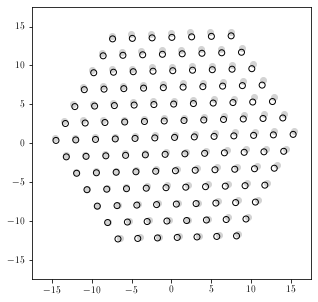

In [10]:
import RealSim_IFS

(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='N127',
                                           fibers_per_side=None,
                                           n_observations='Classic',
                                           rotation_degrees = 1.5,
                                           return_params=True)

fiber_diameter_arcsec = params['fiber_diameter_arcsec']
core_diameter_arcsec = params['core_diameter_arcsec']
n_observations = xc_arr.shape[-1]

print(xpos.shape)

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(xpos[:127,1000],ypos[:127,1000],facecolor = 'lightgrey',edgecolor=None)
# ax.scatter(med_xpos[127:2*127],med_ypos[127:2*127],facecolor = 'lightgrey',edgecolor=None)
# ax.scatter(med_xpos[2*127:3*127],med_ypos[2*127:3*127],facecolor = 'lightgrey',edgecolor=None)

#ax.scatter(xc_arr[:,0],yc_arr[:,0],facecolor = 'None',edgecolor='black')
#ax.scatter(xc_arr[:,1],yc_arr[:,1],facecolor = 'None',edgecolor='black')
ax.scatter(xc_arr[:,2],yc_arr[:,2],facecolor = 'None',edgecolor='black')

ax.set_xlim(-17.5,17.5)
ax.set_ylim(-17.5,17.5)


## Comparison of output from the MaNGA DRP and RealSim-IFS

The input data are the spectra from the RSS files. Because the positions of the fibers in the real data have wavelength-dependent corrections, I will use the median position of the fibers over all wavelenghts for the observational data. The output cube has 0.5 arcsec per pixel.

Here I ran into another memory issue similar to the one documented in the `Apply fibers to cube and obtain fiber arrays` section of the `TNG-100_Kinematics_Tests` notebook.

`MemoryError: Unable to allocate array with shape (1905, 6732, 74, 74) and data type float64`

I will need to turn these components into loops in order to handle files like the RSS files with so many fibers and spectral elements.

To resolve this issue, I added the option of performing the operation in memory chunks to limit the memory demand from the `Fiber_to_Grid()` function.

*Note*: A 0.5 spaxel position correction is required for `RealSim-IFS` when running on MaNGA data to match the lincubes. This comes from the fact that the output grid in `RealSim-IFS` is defined by the output spaxel centroids and not their edges. Therefore, a 0.5 spaxel correction is required to remove the offset between the maps.

In [33]:
input_grid_dims = 37
out_arcsec_per_pixel = 0.5
output_grid_dims = int(input_grid_dims/out_arcsec_per_pixel)
diam_cores_arcsec = 2. 

outfile = 'RSS_TEST_Cube.npy'

if not os.access(outfile,0):
    
    core_x_pixels,core_y_pixels,core_diameter_pixels = RealSim_IFS.Change_Coords(med_xpos+input_grid_dims/2.,
                                                                                 med_ypos+input_grid_dims/2.,
                                                                                 diam_cores_arcsec,
                                                                                 input_grid_dims=input_grid_dims,
                                                                                 output_grid_dims=output_grid_dims)

    import time
    start = time.time()
    out_cube,weight_map = RealSim_IFS.Fiber_to_Grid(rss,core_x_pixels+0.5,core_y_pixels+0.5,core_diameter_pixels,
                                        grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                                        gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                        rlim_pixels=1.6/out_arcsec_per_pixel,use_broadcasting=False)
    print(time.time()-start)

    np.save(outfile,out_cube)

## Plotting the output

Below is the output from applying RealSim to the RSS data from MaNGA. Note that is nearly identical to the white-light images produced by Marvin for this object: https://dr16.sdss.org/marvin/galaxy/7443-12703/. The median fiber positions (along the wavelength dimension) are overlaid as blue dots.

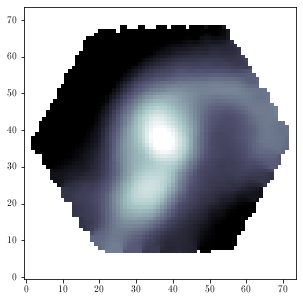

In [34]:
import copy
from matplotlib import cm
cmap = copy.copy(cm.bone)
cmap.set_bad('white')

out_cube = np.load('RSS_TEST_Cube.npy')

wl_image = np.sum(out_cube,axis=0)
wl_image[wl_image==0]=np.nan
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.log10(wl_image),cmap=cmap,origin='lower',vmin=2,vmax=4)
#ax.scatter(core_x_pixels[:381],core_y_pixels[:381],alpha=0.3)

## Dowload and unpack `LINCUBE`

from the DRP for this object.

In [12]:
sas_base_dir = 'rsync://data.sdss.org/dr16/manga/spectro/redux/v2_4_3'

plate = 7443
ifudesign = 12703

filename = 'manga-{PLATE}-{IFUDESIGN}-LINCUBE.fits.gz'.format(PLATE=plate,IFUDESIGN=ifudesign)
target_url = '{}/{}/stack/{}'.format(sas_base_dir,plate,filename)

if not os.access(filename,0):
    rsync_cmd = 'rsync -avz --info=progress2 {} ./{}'.format(target_url,filename)
    start = time.time()
    os.system(rsync_cmd)
    print(time.time()-start)
    
if os.access(filename,0):
    os.system('gunzip -f {}'.format(filename))
filename = filename.replace('.gz','')

6.2333502769470215


## Compare `LINCUBE` with `RealSim` output

Because the spacing in wavelength in the MaNGA LINCUBES are exactly 1 Angstrom, no multiplication by $\Delta \lambda$ is needed to compute the white-light flux.

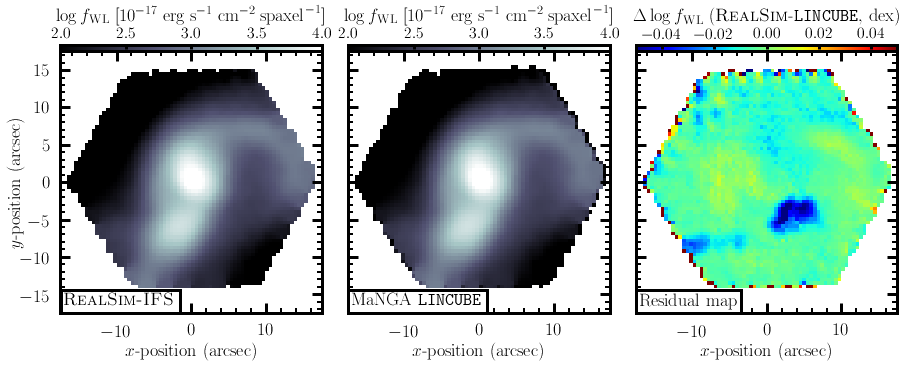

In [51]:
import copy
from matplotlib import cm
cmap = copy.copy(cm.bone)
cmap.set_bad('white')
bbox = dict(facecolor='white', edgecolor='black', boxstyle='square',pad=0.2,lw=3)

def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.,1.0, 1.0, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=3, labelsize=16)
    cbar.set_label(label, color=colour, size=18)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(3)

out_cube = np.load('RSS_TEST_Cube.npy')
lincube = fits.getdata(filename)
fig,axarr = plt.subplots(1,3,figsize=(15,5))
fig.subplots_adjust(wspace=0.1)

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.set_xlim(-17.5,17.5)
    ax.set_ylim(-17.5,17.5)
    ax.set_xlabel(r'$x$-position (arcsec)',fontsize=18)
    
for ax in axarr.flat[-2:]:
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0)

ax = axarr[1]
im = ax.imshow(np.log10(np.sum(lincube,axis=0)),cmap=cmap,origin='lower',vmin=2,vmax=4,extent=(-17.5,17.5,-17.5,17.5))
ax.text(0.014,0.014,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='bottom',transform=ax.transAxes,bbox=bbox)
label = '$\log f_{\mathrm{WL}}\; [10^{-17} \; \mathrm{erg} \; \mathrm{s}^{-1} \; \mathrm{cm}^{-2} \; \mathrm{spaxel}^{-1}]$'
add_colorbar(im,ax,label,colour='black')

ax = axarr[0]
im = ax.imshow(np.log10(wl_image),cmap=cmap,origin='lower',vmin=2,vmax=4,extent=(-17.5,17.5,-17.5,17.5))
add_colorbar(im,ax,label,colour='black')
ax.text(0.014,0.014,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='bottom',transform=ax.transAxes,bbox=bbox)
ax.set_ylabel(r'$y$-position (arcsec)',fontsize=18,labelpad=-5)

ax = axarr[2]
im = ax.imshow(np.log10(wl_image)-np.log10(np.sum(lincube,axis=0)),cmap='jet',origin='lower',vmin=-0.05,vmax=0.05,extent=(-17.5,17.5,-17.5,17.5))
label = r'$\Delta \log f_{\mathrm{WL}}$ (\textsc{RealSim}-\texttt{LINCUBE}, dex)'
ax.text(0.014,0.014,r'Residual map',fontsize=18,color='black',ha='left',va='bottom',transform=ax.transAxes,bbox=bbox)
add_colorbar(im,ax,label,colour='black')

#fig.savefig('RSS_OUTCUBE_Comparison.pdf',bbox_inches='tight')

## Polished Astrometry+DAR plot

A polished plot showing the effects of fibre core astrometric corrections and differential atmospheric refraction.

(1905, 6732)
3622.0 4622.0 10353.0


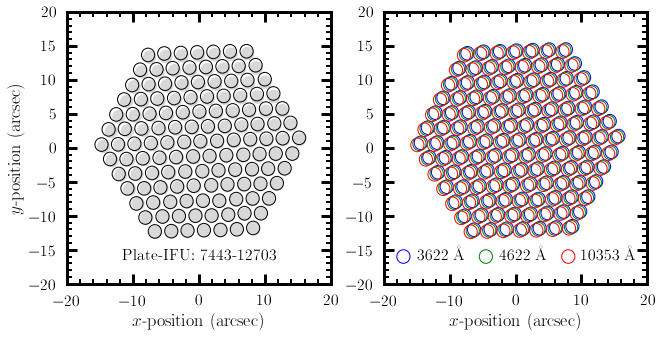

In [52]:
import RealSim_IFS

(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='N127',
                                           fibers_per_side=None,
                                           n_observations='Classic',
                                           rotation_degrees = 2.,
                                           return_params=True)

fiber_diameter_arcsec = params['fiber_diameter_arcsec']
core_diameter_arcsec = params['core_diameter_arcsec']
n_observations = xc_arr.shape[-1]

xpos = hdu['XPOS'].data
ypos = hdu['YPOS'].data
print(xpos.shape)

lam = hdu['WAVE'].data
med_xpos = np.median(xpos,axis=1)
med_ypos = np.median(ypos,axis=1)
lam_index = 1000

print(lam[0],lam[lam_index],lam[-1])

fig,axarr = plt.subplots(1,2,figsize=(10+0.2*2,5))
fig.subplots_adjust(wspace=0.2)

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=16,right=1,top=1)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.set_xlabel(r'$x$-position (arcsec)',fontsize=18)

ax = axarr[0]

ax.set_ylabel(r'$y$-position (arcsec)',fontsize=18)

for xy in zip(xc_arr[:,2],yc_arr[:,2]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor='Grey',alpha=0.3)
    ax.add_artist(fibre)

for xy in zip(med_xpos[:127],med_ypos[:127]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor = 'None',edgecolor='black')
    ax.add_artist(fibre)
    
ax.text(0.5,0.1,"Plate-IFU: {}-{}".format(plate,ifudesign),
        ha='center',va='center',color='black',fontsize=16,transform=ax.transAxes)
ax.set_ylabel(r'$y$-position (arcsec)',fontsize=18)

ax = axarr[1]

for xy in zip(xpos[:127,0],ypos[:127,0]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor = 'None',edgecolor='blue',label='{:.0f} \AA'.format(lam[0]))
    ax.add_artist(fibre)

fibre = Circle(xy=(-17,0.1*40-20),radius=1,transform=ax.transData,facecolor = 'None',edgecolor='blue',label='{:.0f} \AA'.format(lam[0]))
ax.add_artist(fibre)
ax.text(-15,0.1*40-20,r'{:.0f} \AA'.format(lam[0]),transform=ax.transData,ha='left',va='center',fontsize=16)


for xy in zip(xpos[:127,lam_index],ypos[:127,lam_index]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor = 'None',edgecolor='green',label='{:.0f} \AA'.format(lam[0]))
    ax.add_artist(fibre)
    
fibre = Circle(xy=(-4.5,0.1*40-20),radius=1,transform=ax.transData,facecolor = 'None',edgecolor='green',label='{:.0f} \AA'.format(lam[lam_index]))
ax.add_artist(fibre)
ax.text(-2.5,0.1*40-20,r'{:.0f} \AA'.format(lam[lam_index]),transform=ax.transData,ha='left',va='center',fontsize=16)

    
for xy in zip(xpos[:127,-1],ypos[:127,-1]):
    fibre = Circle(xy=xy,radius=1,transform=ax.transData,facecolor = 'None',edgecolor='red',label='{:.0f} \AA'.format(lam[0]))
    ax.add_artist(fibre)
    
fibre = Circle(xy=(8,0.1*40-20),radius=1,transform=ax.transData,facecolor = 'None',edgecolor='red',label='{:.0f} \AA'.format(lam[-1]))
ax.add_artist(fibre)
ax.text(10,0.1*40-20,r'{:.0f} \AA'.format(lam[-1]),transform=ax.transData,ha='left',va='center',fontsize=16)

fig.savefig('RSS_Astrometry_Demo.pdf',bbox_inches='tight')

## Reconstructing at specific wavlengths

A wrapper for `RealSim-IFS` which uses the astrometrically corrected fibre positions in each wavelength channel of the MaNGA RSS file. Three slices of the cube are reconstructed.

In [53]:
input_grid_dims = 37
out_arcsec_per_pixel = 0.5
output_grid_dims = int(input_grid_dims/out_arcsec_per_pixel)
diam_cores_arcsec = 2. 

index1, index2, index3 = 0,2500,5000
out_cube = np.zeros((3,output_grid_dims,output_grid_dims))
for i,lam_index in enumerate([index1, index2, index3]):
    core_x_pixels,core_y_pixels,core_diameter_pixels = RealSim_IFS.Change_Coords(xpos[:,lam_index]+input_grid_dims/2.,
                                                                                 ypos[:,lam_index]+input_grid_dims/2.,
                                                                                 diam_cores_arcsec,
                                                                                 input_grid_dims=input_grid_dims,
                                                                                 output_grid_dims=output_grid_dims)

    import time
    start = time.time()
    out_slice,weight_map = RealSim_IFS.Fiber_to_Grid(rss[:,lam_index].reshape(-1,1),core_x_pixels+0.5,core_y_pixels+0.5,core_diameter_pixels,
                                        grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                                        gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                        rlim_pixels=1.6/out_arcsec_per_pixel,use_broadcasting=False)
    print(time.time()-start)
    out_cube[i] = out_slice[0]
    

outfile = 'RSS_TEST_Slices.npy'
np.save(outfile,out_cube)

0.7558333873748779
0.7378640174865723
0.7376923561096191


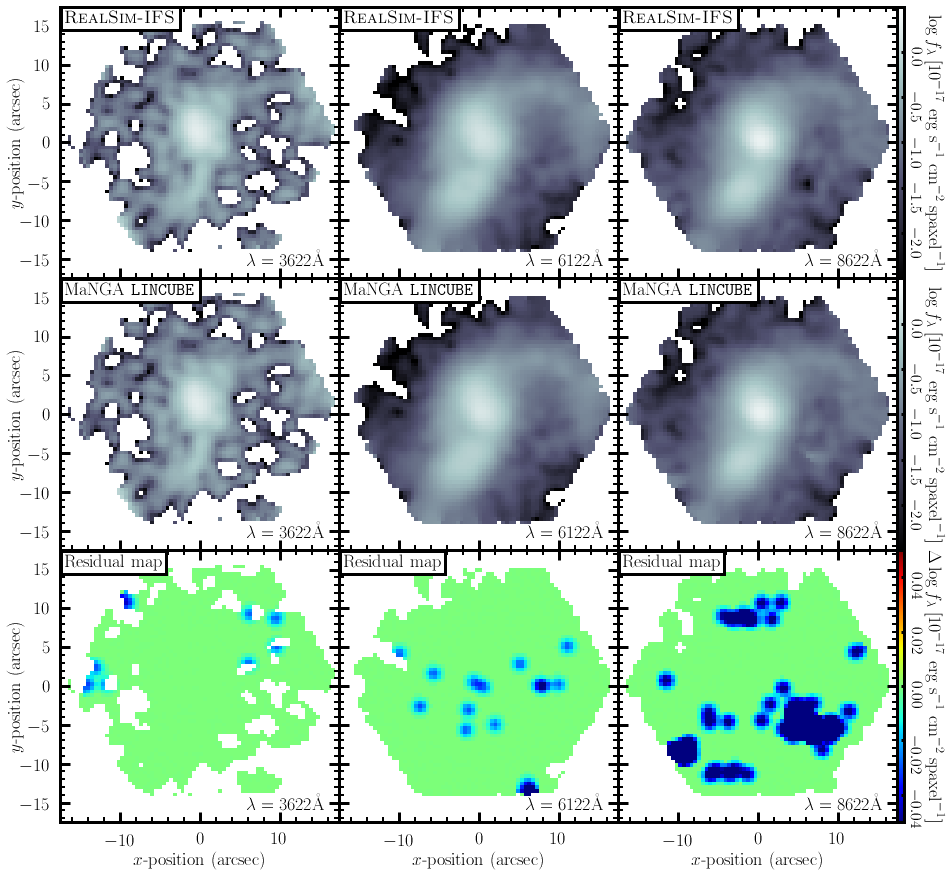

In [54]:
import copy
from matplotlib import cm
cmap = copy.copy(cm.bone)
cmap.set_bad('white')
bbox = dict(facecolor='white', edgecolor='black', boxstyle='square',pad=0.2,lw=3)

def add_colorbar(im,ax,label,colour='white',dropticks=True):
    axin = ax.inset_axes(
            [1.,0., 0.025, 1.], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='vertical')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=0,
                        labelbottom=0,labelleft=0,labelright=1,top=0,bottom=0,right=1,left=0,
                        width=3, labelsize=16,labelrotation=270)
    if dropticks:
        plt.setp(axin.get_yticklabels()[0], visible=False)  
        plt.setp(axin.get_yticklabels()[-1], visible=False)  
    
    cbar.set_label(label, color=colour, size=18,rotation=270,labelpad=20)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(3)

lincube = fits.getdata(filename)
out_cube = np.load('RSS_TEST_Slices.npy')
fig,axarr = plt.subplots(3,3,figsize=(15,15))
fig.subplots_adjust(wspace=0.0,hspace=0.)

axarr = axarr.flatten()

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0,labelbottom=0)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.set_xlim(-17.5,17.5)
    ax.set_ylim(-17.5,17.5)
    
for ax in axarr[6:]:
    ax.tick_params(axis='both',which='major',labelbottom=1)
    ax.set_xlabel(r'$x$-position (arcsec)',fontsize=18)
    
for ax in axarr[[0,3,6]]:
    ax.tick_params(axis='both',which='major',labelleft=1)
    ax.set_ylabel(r'$y$-position (arcsec)',fontsize=18,labelpad=-5)
    
for ax in axarr.flat[-2:]:
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0)

ax = axarr[0]
im = ax.imshow(np.log10(out_cube[0]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index1]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[3]
im = ax.imshow(np.log10(lincube[index1]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index1]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[6]
im = ax.imshow(np.log10(out_cube[0])-np.log10(lincube[index1]),cmap='jet',origin='lower',vmin=-0.1,vmax=0.1,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index1]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[1]
im = ax.imshow(np.log10(out_cube[1]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index2]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[4]
im = ax.imshow(np.log10(lincube[index2]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index2]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[7]
im = ax.imshow(np.log10(out_cube[1])-np.log10(lincube[index2]),cmap='jet',origin='lower',vmin=-0.1,vmax=0.1,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index2]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[2]
im = ax.imshow(np.log10(out_cube[2]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index3]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
label = r'$\log f_{\lambda}\; [10^{-17} \; \mathrm{erg} \; \mathrm{s}^{-1} \; \mathrm{cm}^{-2} \; \mathrm{spaxel}^{-1}]$'
add_colorbar(im,ax,label,colour='black')

ax = axarr[5]
im = ax.imshow(np.log10(lincube[index3]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index3]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
add_colorbar(im,ax,label,colour='black')

ax = axarr[8]
im = ax.imshow(np.log10(out_cube[2])-np.log10(lincube[index3]),cmap='jet',origin='lower',vmin=-0.05,vmax=0.05,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index3]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
label = r'$\Delta \log f_{\lambda}\; [10^{-17} \; \mathrm{erg} \; \mathrm{s}^{-1} \; \mathrm{cm}^{-2} \; \mathrm{spaxel}^{-1}]$'
add_colorbar(im,ax,label,colour='black',dropticks=False)

#fig.savefig('RSS_Slice_Demo.pdf',bbox_inches='tight')

## Now include masking of RSS data

The inverse variance maps in the RSS data can be used to indicate which spectra elements of which fibers contain untrustworthy data. In this next test, I show that by properly masking the RSS data with inverse variance values of zero, the cavities in the map disappear. The cavities come from over-estimation of the normalization term for data which include `NaNs` (originally set to zero by `RealSim-IFS`). Ultimately, fixing this issue required a code update in `RealSim_IFS`. Many thanks to David Law who recognized the source of this issue immediately from the plot above.

Below, I use an inverse variance data in the RSS file to mask RSS flux data where the inverse variance is equal to zero (variance arbitrarily high). This makes a perfect reproduction of the maps.

In [10]:
import importlib
from copy import copy
importlib.reload(RealSim_IFS)

input_grid_dims = 37
out_arcsec_per_pixel = 0.5
output_grid_dims = int(input_grid_dims/out_arcsec_per_pixel)
diam_cores_arcsec = 2. 

ivar = hdu['IVAR'].data
rss_ivar = copy(rss)
rss_ivar[ivar==0.]=np.nan

index1, index2, index3 = 0,2500,5000
out_cube = np.zeros((3,output_grid_dims,output_grid_dims))
for i,lam_index in enumerate([index1, index2, index3]):
    core_x_pixels,core_y_pixels,core_diameter_pixels = RealSim_IFS.Change_Coords(xpos[:,lam_index]+input_grid_dims/2.,
                                                                                 ypos[:,lam_index]+input_grid_dims/2.,
                                                                                 diam_cores_arcsec,
                                                                                 input_grid_dims=input_grid_dims,
                                                                                 output_grid_dims=output_grid_dims)

    import time
    start = time.time()
    out_slice,weight_map = RealSim_IFS.Fiber_to_Grid(rss_ivar[:,lam_index].reshape(-1,1),core_x_pixels+0.5,core_y_pixels+0.5,core_diameter_pixels,
                                        grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                                        gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                        rlim_pixels=1.6/out_arcsec_per_pixel,use_broadcasting=False)
    print(time.time()-start)
    out_cube[i] = out_slice[0]
    

outfile = 'RSS_TEST_Slices_IVAR.npy'
np.save(outfile,out_cube)

0.7549843788146973
0.7446293830871582
0.7468531131744385


2.0042966841771204e-08
1.9913533932935934e-08
1.9217606006538546e-08


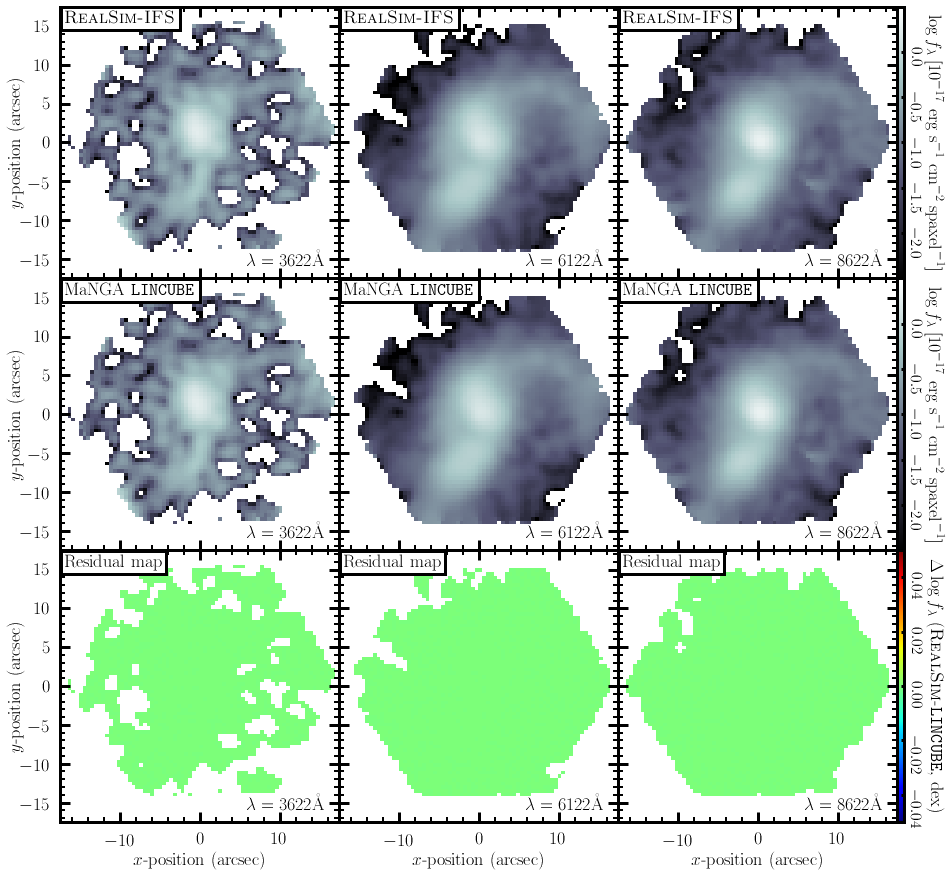

In [13]:
import copy
from matplotlib import cm
cmap = copy.copy(cm.bone)
cmap.set_bad('white')
bbox = dict(facecolor='white', edgecolor='black', boxstyle='square',pad=0.2,lw=3)

def add_colorbar(im,ax,label,colour='white',dropticks=True):
    axin = ax.inset_axes(
            [1.,0., 0.025, 1.], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='vertical')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=0,
                        labelbottom=0,labelleft=0,labelright=1,top=0,bottom=0,right=1,left=0,
                        width=3, labelsize=16,labelrotation=270)
    if dropticks:
        plt.setp(axin.get_yticklabels()[0], visible=False)  
        plt.setp(axin.get_yticklabels()[-1], visible=False)  
    
    cbar.set_label(label, color=colour, size=18,rotation=270,labelpad=20)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(3)

lincube = fits.getdata(filename)

out_cube = np.load('RSS_TEST_Slices_IVAR.npy')
fig,axarr = plt.subplots(3,3,figsize=(15,15))
fig.subplots_adjust(wspace=0.0,hspace=0.)

axarr = axarr.flatten()

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0,labelbottom=0)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.set_xlim(-17.5,17.5)
    ax.set_ylim(-17.5,17.5)
    
for ax in axarr[6:]:
    ax.tick_params(axis='both',which='major',labelbottom=1)
    ax.set_xlabel(r'$x$-position (arcsec)',fontsize=18)
    
for ax in axarr[[0,3,6]]:
    ax.tick_params(axis='both',which='major',labelleft=1)
    ax.set_ylabel(r'$y$-position (arcsec)',fontsize=18,labelpad=-5)
    
for ax in axarr.flat[-2:]:
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1,labelleft=0)

ax = axarr[0]
im = ax.imshow(np.log10(out_cube[0]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index1]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[3]
im = ax.imshow(np.log10(lincube[index1]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index1]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[6]
im = ax.imshow(np.log10(out_cube[0])-np.log10(lincube[index1]),cmap='jet',origin='lower',vmin=-0.1,vmax=0.1,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index1]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[1]
im = ax.imshow(np.log10(out_cube[1]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index2]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[4]
im = ax.imshow(np.log10(lincube[index2]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index2]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[7]
im = ax.imshow(np.log10(out_cube[1])-np.log10(lincube[index2]),cmap='jet',origin='lower',vmin=-0.1,vmax=0.1,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index2]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)

ax = axarr[2]
im = ax.imshow(np.log10(out_cube[2]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'{\scshape RealSim-IFS}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index3]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
label = r'$\log f_{\lambda}\; [10^{-17} \; \mathrm{erg} \; \mathrm{s}^{-1} \; \mathrm{cm}^{-2} \; \mathrm{spaxel}^{-1}]$'
add_colorbar(im,ax,label,colour='black')

ax = axarr[5]
im = ax.imshow(np.log10(lincube[index3]),cmap=cmap,origin='lower',vmin=-2.5,vmax=0.5,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'MaNGA \texttt{LINCUBE}',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index3]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
add_colorbar(im,ax,label,colour='black')

ax = axarr[8]
im = ax.imshow(np.log10(out_cube[2])-np.log10(lincube[index3]),cmap='jet',origin='lower',vmin=-0.05,vmax=0.05,extent=(-17.5,17.5,-17.5,17.5),aspect='auto')
ax.text(0.015,1-0.015,r'Residual map',fontsize=18,color='black',ha='left',va='top',transform=ax.transAxes,bbox=bbox)
ax.text(1-0.05,0.03,r'$\lambda={{{:.0f}}}$\AA'.format(lam[index3]),fontsize=18,color='black',ha='right',va='bottom',transform=ax.transAxes,bbox=None)
label = r'$\Delta \log f_{\lambda}$ (\textsc{RealSim}-\texttt{LINCUBE}, dex)'
add_colorbar(im,ax,label,colour='black',dropticks=False)

print(np.nanmedian(np.log10(out_cube[0])-np.log10(lincube[index1])))
print(np.nanmedian(np.log10(out_cube[1])-np.log10(lincube[index2])))
print(np.nanmedian(np.log10(out_cube[2])-np.log10(lincube[index3])))
#fig.savefig('RSS_Slice_Demo_IVAR.pdf',bbox_inches='tight')